In [1]:
import itertools
import math

import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import poisson

# Parameters

In [2]:
initial_cases = 10

# sweep over [0.0 - 1.0]  # based on travel rates
imported_cases_per_step = .5  # really, there's a cost to setting this too, if we make it part of the action space

# .97 - .98
# .97 ** (6*30 / 4) == 0.25
# .98 ** (6*30 / 4) == 0.4
#   --> credence assigned to NO vaccine in 6 months
#        strikes balance of giving a fair chance of 6 month vaccine; while not giving high chance to vaccine in 2-months
discount = 0.99

# time step: ~4 days  (1 generation period)
num_population = 1000

In [3]:
# is this really a fair form? 
# wouldn't keeping everyone home for 6 weeks have some finite cost?

# Cost of setting R
R_0 = 2.5   # 2.8? #3?  look up; depends on the place

# sweep:  [1, 3]
power = 2

# average person's annual economic contribution: $50,000?
economic_contribution_annual = 50000
economic_contribution_2_weeks = economic_contribution_annual * 2.0 / 52
cost_to_keep_half_home = num_population / 2 * economic_contribution_2_weeks

# want: cost_of_r(R_0 / 4) == cost_to_keep_half_home
# Better: how much economic loss has the US had, to keep R ~= 1
# (1/((R_0/4)**power) - 1/(R_0 ** power)) * scale_factor == cost_to_keep_half_home
# scale_factor = cost_to_keep_half_home / (1/((R_0/4)**power) - 1/(R_0 ** power))

# population of 100,000:
# R = 1 for 4 days  ~=  100 people getting sick (25 ppl / day * 4 days)
# every 20 days: 500 people sick -> 5 person dead

# cost_of_r(1.0) == cost_of_n(100) == cost of 1 death + other bad effects ?= $4,000,000
# [1/(1 ** power) - 1/(R_0 ** power)] * scale_factor == 100
# scale_factor = 100 / [1 - 1/(R_0 ** power)]


def cost_of_r(r, power=power):
    baseline = 1/(R_0 ** power)
    actual = 1/(r ** power)
    
    scale_factor = 100 # cost_to_keep_half_home / (1/((num_population/4)**power) - 1/(R_0 ** power))
    
    if r >= R_0:
        return 0
    else:
        return (actual - baseline) * scale_factor

14
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.5 2.  2.5]


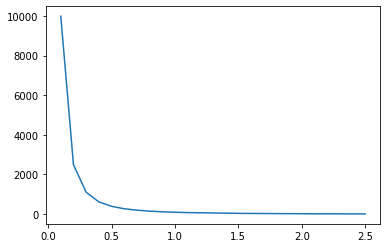

In [4]:
rs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 2.5])
costs_of_r = [cost_of_r(r) for r in rs]
sns.lineplot(x=rs, y=costs_of_r)
actions = rs
num_actions = len(actions)
print(num_actions)
print(actions)

In [5]:
cost_of_r(1.0) / cost_of_r(0.5)

0.21875

In [6]:
# Cost of N (number of cases)
# assume cost of someone getting sick is $40,000

'''fraction_need_hospital = 0.04
cost_per_hospital_visit = 50000
cost_per_death = 1e6

# cost_of_n(n) == n
# cost_of_r(1.0) == cost_of_n(100) == 100

hospital_capacity = 25 # 5% of population #  20000

death_rate_hospital = 0.25
death_rate_neglected = 0.9'''


def cost_of_n(n):
    if n <= 0:
        return 0
    else:
        return n
    
    '''    num_need_hospital = n * fraction_need_hospital
        num_hospital = min(num_need_hospital, hospital_capacity)
        num_neglected = num_need_hospital - num_hospital
        num_deaths = num_neglected * death_rate_neglected + num_hospital * death_rate_hospital
        
        return cost_per_hospital_visit * num_hospital + cost_per_death * num_deaths '''

297

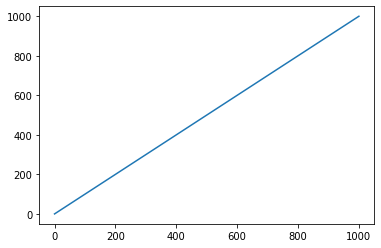

In [7]:
ns = sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     [1_000]
     #sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     #sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], []) + \
     
# #list(range(num_population))
costs_of_n = [cost_of_n(n) for n in ns]
sns.lineplot(x=ns, y=costs_of_n)
states = ns
num_states = len(states)
num_states

In [8]:
lookup = dict([(x, i) for i in range(num_states - 1) for x in range(states[i], states[i+1])] + [(num_population, len(states) - 1)])
def bucket_state_index(new_state):
    if new_state < 0:
        raise Exception('Cannot have negative case count')
    elif new_state in lookup:
        return lookup[new_state]
    else:
        return lookup[num_population]
list(lookup.items())[-10:]

[(991, 295),
 (992, 295),
 (993, 295),
 (994, 295),
 (995, 295),
 (996, 295),
 (997, 295),
 (998, 295),
 (999, 295),
 (1000, 296)]

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [10]:
find_nearest(states, 2329)

1000

In [11]:
def expected_new_state(current_state, action):
    r_effective = action
    current_cases = current_state
    
    fraction_susceptible = 1 # (num_population - current_cases) / num_population
    # TODO: may need better way to bound susceptible population,
    # to account for immunity
    # One option: fraction_susceptible = 1 always, and just bound new_state by num_population

    # Better solution: keep track of how many people are susceptible NOW, based on some immunity time
    expected_new_cases = (current_cases * r_effective + imported_cases_per_step) * fraction_susceptible

    return expected_new_cases

In [12]:
expected_new_state(2330, 2.0)

4660.5

In [13]:
def new_state_distribution(state, action):
    lam = expected_new_state(state, action)
    # TODO: change to negative binomial; look up constant in literature for COVID
    return poisson(lam)

In [14]:
distribution = new_state_distribution(2330, 2.0)
distribution.mean(), distribution.var(), distribution.median()

(4660.5, 4660.5, 4660.0)

In [15]:
distribution.cdf(4750) - distribution.cdf(4700)

0.18443092046258014

In [16]:
def bucketed_distribution(distribution, states):
    probs = np.zeros_like(states, dtype=float)
    for state_idx in range(num_states - 1):
        low_state = states[state_idx]
        high_state = states[state_idx + 1]
        probs[state_idx] = (distribution.cdf(high_state) - distribution.cdf(low_state))
    probs[num_states - 1] = 1 - distribution.cdf(states[num_states - 1])
    return probs

In [17]:
bucket_distr = bucketed_distribution(distribution, states)
[bucket_distr[bucket_state_index(x)] for x in [4500, 4550, 4600, 4650, 4700, 4750, 4800]]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [18]:
transition_probabilities = np.zeros((num_states, num_actions, num_states))
transition_probabilities.shape

(297, 14, 297)

In [19]:
for state_idx in tqdm(range(num_states)):
    for action_idx in range(num_actions):
        distribution = new_state_distribution(states[state_idx], actions[action_idx])
        bucket_distr = bucketed_distribution(distribution, states)
        transition_probabilities[state_idx, action_idx] = bucket_distr
        #print(len(bucket_distr))

100%|██████████| 297/297 [04:55<00:00,  1.01it/s]


In [42]:
transition_probabilities

array([[[3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        ...,
        [3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.03265330e-001, 7.58163325e-002, 1.26360554e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       [[3.29286982e-001, 9.87860945e-002, 1.97572189e-002, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.47609713e-001, 1.21663399e-001, 2.83881265e-002, ...,
         0.00000000e+000, 0.00000000e+

In [20]:
def reward(state, action):
    n = state
    r_effective = action
    return -cost_of_n(n) - cost_of_r(r_effective)  # should this be cost_of_n(new_state)?

In [21]:
def step(state_idx, action_idx):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    distr = new_state_distribution(states[state_idx], actions[action_idx])
    new_state = distr.rvs()
    
    # TODO: change to an actual expectation
    # ensure number of infected people does not exceed entire population
    new_state = min(new_state, num_population)
    new_state_idx = bucket_state_index(new_state)  # discretized case count
    
    resulting_reward = reward(states[state_idx], actions[action_idx])
    
    return new_state_idx, resulting_reward

In [22]:
state_idx = bucket_state_index(322)
print(f'original state: {states[state_idx]}')

action_idx = 2
print(f'action: {actions[action_idx]}')

new_state_idx, resulting_reward = step(state_idx, action_idx)
print('new state: ', states[new_state_idx])
print('reward : ', resulting_reward)

original state: 320
action: 0.3
new state:  102
reward :  -1415.111111111111


## Initial Conditions

## Value Iteration

In [23]:
def select_action(state_idx, state_values):
    rewards = np.zeros_like(actions, dtype=float)
    for action_idx in range(len(actions)):
        distr = new_state_distribution(states[state_idx], actions[action_idx])
        probs = transition_probabilities[state_idx, action_idx] # bucketed_distribution(distr, states)
        
        step_reward = reward(states[state_idx], actions[action_idx]) 
        # TODO: in general, this should be coupled with the probability of reaching a given state. 
        # Here, we've made them independent, because we've made the reward be a function just of the state you're in and the action you take -- not of the next state you end up reaching
        
        rewards[action_idx] = (probs * (step_reward + state_values * discount)).sum()
    best_action_idx = rewards.argmax()
    return best_action_idx, rewards[best_action_idx] # action, lifetime value of taking this action

In [24]:
def state_value(state_idx, state_values):
    best_action, max_reward = select_action(state_idx, state_values)
    return max_reward # lifetime value of taking the best action from this state

In [25]:
state_values = np.random.random(num_states) * -1000 - 1000
best_action_idx = np.zeros_like(state_values)

for i in tqdm(range(100)):
    new_state_values = np.zeros_like(state_values, dtype=float)
    for state_idx in range(num_states):
        best_action_idx[state_idx], new_state_values[state_idx] = select_action(state_idx, state_values)
    diffs = abs(state_values - new_state_values)
    print(diffs.max())
    state_values = new_state_values

  1%|          | 1/100 [00:02<04:04,  2.47s/it]

1546.9242473557065


  2%|▏         | 2/100 [00:04<04:01,  2.47s/it]

738.6063206577319


  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

498.05814777077967


  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

364.25064087759483


  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

291.9289101733193


  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

218.53862838787654


  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

169.06479079545988


  8%|▊         | 8/100 [00:19<03:50,  2.51s/it]

146.70940798027823


  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

127.52302881576543


 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

116.22889748835769


 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

107.99077383381791


 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

105.88735527596964


 13%|█▎        | 13/100 [00:32<03:36,  2.48s/it]

101.77196663657105


 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

80.64092277966483


 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

61.13933163648653


 16%|█▌        | 16/100 [00:39<03:28,  2.49s/it]

45.12079996154898


 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

33.66168132471648


 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

24.94863519082446


 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

18.332859456611914


 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

13.442065461098537


 21%|██        | 21/100 [00:52<03:16,  2.48s/it]

9.844686904220907


 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

7.182629482527773


 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

5.212313798545438


 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

3.759729429091749


 25%|██▌       | 25/100 [01:02<03:05,  2.47s/it]

2.7011042335561797


 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

1.9373620638825741


 27%|██▋       | 27/100 [01:06<02:59,  2.45s/it]

1.3938094648465267


 28%|██▊       | 28/100 [01:09<02:57,  2.46s/it]

1.0014310001297417


 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

0.7182996676920084


 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

0.515073634750479


 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

0.37014721066771017


 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

0.2653724434248943


 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

0.18954967768513598


 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

0.13519364985495486


 35%|███▌      | 35/100 [01:26<02:41,  2.49s/it]

0.09636860769205668


 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

0.06867163590322889


 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

0.04892542082234286


 38%|███▊      | 38/100 [01:34<02:35,  2.51s/it]

0.034852788802709256


 39%|███▉      | 39/100 [01:36<02:33,  2.51s/it]

0.02482591738953488


 40%|████      | 40/100 [01:39<02:30,  2.51s/it]

0.017682762489130255


 41%|████      | 41/100 [01:41<02:27,  2.50s/it]

0.012594470270414604


 42%|████▏     | 42/100 [01:44<02:25,  2.51s/it]

0.00897015338523488


 43%|████▎     | 43/100 [01:46<02:22,  2.50s/it]

0.006388713269188884


 44%|████▍     | 44/100 [01:49<02:20,  2.50s/it]

0.004550118521365221


 45%|████▌     | 45/100 [01:51<02:17,  2.50s/it]

0.0032406285936303902


 46%|████▌     | 46/100 [01:54<02:15,  2.50s/it]

0.002307990417648398


 47%|████▋     | 47/100 [01:56<02:12,  2.50s/it]

0.001643756780140393


 48%|████▊     | 48/100 [01:59<02:10,  2.51s/it]

0.0011706857640092494


 49%|████▉     | 49/100 [02:02<02:08,  2.51s/it]

0.0008337629788002232


 50%|█████     | 50/100 [02:04<02:06,  2.53s/it]

0.0005938059493928449


 51%|█████     | 51/100 [02:07<02:03,  2.52s/it]

0.0004229083524478483


 52%|█████▏    | 52/100 [02:09<02:00,  2.52s/it]

0.00030119505663606105


 53%|█████▎    | 53/100 [02:12<01:57,  2.50s/it]

0.0002145108774129767


 54%|█████▍    | 54/100 [02:14<01:54,  2.49s/it]

0.00015277445436367998


 55%|█████▌    | 55/100 [02:16<01:51,  2.49s/it]

0.00010880581976380199


 56%|█████▌    | 56/100 [02:19<01:48,  2.48s/it]

7.749139331281185e-05


 57%|█████▋    | 57/100 [02:21<01:46,  2.48s/it]

5.5189291742863134e-05


 58%|█████▊    | 58/100 [02:24<01:44,  2.48s/it]

3.9305753489315975e-05


 59%|█████▉    | 59/100 [02:26<01:41,  2.48s/it]

2.7993516596325208e-05


 60%|██████    | 60/100 [02:29<01:39,  2.48s/it]

1.9936953322030604e-05


 61%|██████    | 61/100 [02:31<01:37,  2.49s/it]

1.419907493982464e-05


 62%|██████▏   | 62/100 [02:34<01:34,  2.50s/it]

1.0112566087627783e-05


 63%|██████▎   | 63/100 [02:36<01:32,  2.50s/it]

7.202158485597465e-06


 64%|██████▍   | 64/100 [02:39<01:30,  2.50s/it]

5.129370038048364e-06


 65%|██████▌   | 65/100 [02:41<01:27,  2.50s/it]

3.65313098882325e-06


 66%|██████▌   | 66/100 [02:44<01:25,  2.50s/it]

2.6017569325631484e-06


 67%|██████▋   | 67/100 [02:46<01:22,  2.50s/it]

1.852968125604093e-06


 68%|██████▊   | 68/100 [02:49<01:19,  2.49s/it]

1.3196813597460277e-06


 69%|██████▉   | 69/100 [02:51<01:17,  2.49s/it]

9.398763722856529e-07


 70%|███████   | 70/100 [02:54<01:14,  2.49s/it]

6.693780960631557e-07


 71%|███████   | 71/100 [02:56<01:12,  2.49s/it]

4.7673074732301757e-07


 72%|███████▏  | 72/100 [02:59<01:09,  2.49s/it]

3.3952710509765893e-07


 73%|███████▎  | 73/100 [03:01<01:07,  2.48s/it]

2.418109943391755e-07


 74%|███████▍  | 74/100 [03:04<01:04,  2.48s/it]

1.7221645975951105e-07


 75%|███████▌  | 75/100 [03:06<01:01,  2.47s/it]

1.226544554810971e-07


 76%|███████▌  | 76/100 [03:09<00:59,  2.47s/it]

8.735241863178089e-08


 77%|███████▋  | 77/100 [03:11<00:56,  2.47s/it]

6.221398507477716e-08


 78%|███████▊  | 78/100 [03:14<00:54,  2.48s/it]

4.430694389156997e-08


 79%|███████▉  | 79/100 [03:16<00:52,  2.48s/it]

3.155673766741529e-08


 80%|████████  | 80/100 [03:19<00:49,  2.49s/it]

2.247452357551083e-08


 81%|████████  | 81/100 [03:21<00:47,  2.50s/it]

1.6006197256501764e-08


 82%|████████▏ | 82/100 [03:24<00:44,  2.49s/it]

1.1399606592021883e-08


 83%|████████▎ | 83/100 [03:26<00:42,  2.49s/it]

8.118149708025157e-09


 84%|████████▍ | 84/100 [03:29<00:39,  2.48s/it]

5.782567313872278e-09


 85%|████████▌ | 85/100 [03:31<00:37,  2.47s/it]

4.117282514926046e-09


 86%|████████▌ | 86/100 [03:34<00:34,  2.48s/it]

2.9331204132176936e-09


 87%|████████▋ | 87/100 [03:36<00:32,  2.48s/it]

2.089109329972416e-09


 88%|████████▊ | 88/100 [03:39<00:29,  2.49s/it]

1.4879333321005106e-09


 89%|████████▉ | 89/100 [03:41<00:27,  2.48s/it]

1.0595613275654614e-09


 90%|█████████ | 90/100 [03:43<00:24,  2.49s/it]

7.539711077697575e-10


 91%|█████████ | 91/100 [03:46<00:22,  2.48s/it]

5.366018740460277e-10


 92%|█████████▏| 92/100 [03:48<00:19,  2.49s/it]

3.828972694464028e-10


 93%|█████████▎| 93/100 [03:51<00:17,  2.48s/it]

2.7284841053187847e-10


 94%|█████████▍| 94/100 [03:53<00:14,  2.48s/it]

1.9463186617940664e-10


 95%|█████████▌| 95/100 [03:56<00:12,  2.47s/it]

1.382431946694851e-10


 96%|█████████▌| 96/100 [03:58<00:09,  2.47s/it]

9.822542779147625e-11


 97%|█████████▋| 97/100 [04:01<00:07,  2.46s/it]

7.09405867382884e-11


 98%|█████████▊| 98/100 [04:03<00:04,  2.47s/it]

4.9112713895738125e-11


 99%|█████████▉| 99/100 [04:06<00:02,  2.49s/it]

3.637978807091713e-11


100%|██████████| 100/100 [04:08<00:00,  2.49s/it]

2.546585164964199e-11


## State Values

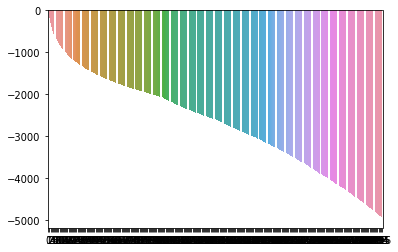

In [26]:
#sns.barplot(list(range(num_population)),
#            [state_values[bucket_state_index(n)] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [state_values[state_idx] for state_idx in range(num_states)])

In [27]:
state_values.dtype

dtype('float64')

## State Actions

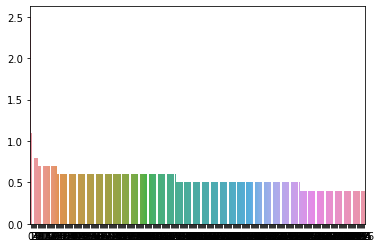

In [28]:
#sns.barplot(list(range(num_population)),
#            [actions[best_action_idx[bucket_state_index(n)]] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [actions[int(best_action_idx[n])] for n in range(num_states)])

In [39]:
{states[i]: actions[int(idx)] for i, idx in enumerate(best_action_idx)}

{0: 2.5,
 1: 1.1,
 2: 0.9,
 3: 0.8,
 4: 0.8,
 5: 0.8,
 6: 0.8,
 7: 0.7,
 8: 0.7,
 9: 0.7,
 10: 0.7,
 11: 0.7,
 12: 0.7,
 13: 0.7,
 14: 0.7,
 15: 0.7,
 16: 0.7,
 17: 0.7,
 18: 0.7,
 19: 0.7,
 20: 0.7,
 21: 0.7,
 22: 0.7,
 23: 0.7,
 24: 0.6,
 25: 0.6,
 26: 0.6,
 27: 0.6,
 28: 0.6,
 29: 0.6,
 30: 0.6,
 31: 0.6,
 32: 0.6,
 33: 0.6,
 34: 0.6,
 35: 0.6,
 36: 0.6,
 37: 0.6,
 38: 0.6,
 39: 0.6,
 40: 0.6,
 41: 0.6,
 42: 0.6,
 43: 0.6,
 44: 0.6,
 45: 0.6,
 46: 0.6,
 47: 0.6,
 48: 0.6,
 49: 0.6,
 50: 0.6,
 51: 0.6,
 52: 0.6,
 53: 0.6,
 54: 0.6,
 55: 0.6,
 56: 0.6,
 57: 0.6,
 58: 0.6,
 59: 0.6,
 60: 0.6,
 61: 0.6,
 62: 0.6,
 63: 0.6,
 64: 0.6,
 65: 0.6,
 66: 0.6,
 67: 0.6,
 68: 0.6,
 69: 0.6,
 70: 0.6,
 71: 0.6,
 72: 0.6,
 73: 0.6,
 74: 0.6,
 75: 0.6,
 76: 0.6,
 77: 0.6,
 78: 0.6,
 79: 0.6,
 80: 0.6,
 81: 0.6,
 82: 0.6,
 83: 0.6,
 84: 0.6,
 85: 0.6,
 86: 0.6,
 87: 0.6,
 88: 0.6,
 89: 0.6,
 90: 0.6,
 91: 0.6,
 92: 0.6,
 93: 0.6,
 94: 0.6,
 95: 0.6,
 96: 0.6,
 97: 0.6,
 98: 0.6,
 99: 0.6,
 100: 0.6,

In [30]:
# Roll-Out Using Optimal Policy

initial_cases = 100
current_state_idx = bucket_state_index(initial_cases)
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state_idx]

for i in tqdm(range(100)):
    action_idx = int(best_action_idx[current_state_idx])
    new_state_idx, new_reward = step(current_state_idx, action_idx)
    total_reward += new_reward * current_discount
    
    current_state_idx = new_state_idx
    current_discount *= discount
    
    action_history.append(actions[action_idx])
    state_history.append(states[current_state_idx])

100%|██████████| 100/100 [00:00<00:00, 1355.74it/s]


In [31]:
total_reward

-8544.258770457232

## Case Counts

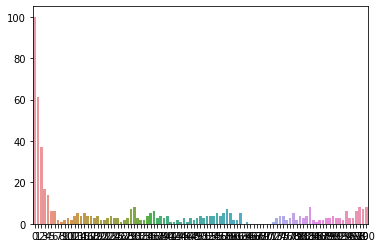

In [32]:
sns.barplot(x=list(range(len(state_history))), y=state_history)

## R(t)

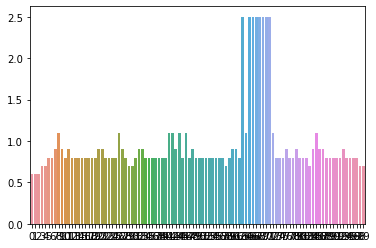

In [40]:
sns.barplot(x=list(range(len(action_history))), y=action_history)